# Generating Visualizations from Data

The following code replicates the data visualizations from the article. Aggregate-level data is provided for replication purposes (in the [`data`](./data/) subdirectory of the directory this notebook is in), but for the purposes of preserving Craigslist user privacy, no individual post-level data is presented in this repository (these often include home street addresses and longitude/latitude values specific to these addresses). All of the code necessary to produce the aggregate-level data used in this notebook on the basis of individual post data, however, is included here and in [`01_analysis.ipynb`](./01_analysis.ipynb) in this same directory.

## Replication Instructions

This code has been tested in an [Anaconda](https://www.anaconda.com/) Python 3.9 environment and can be replicated (after installing Anaconda) by running the following line of code in a terminal window:

```bash
conda create -n repl_env anaconda==2021.11=py39_0 -y
```

Then, activate the environment (via `conda activate repl_env`) and run the following within the environment to install all of the packages necessary to run the code in this notebook:

```bash
pip install geopandas contextily mapclassify lifelines
```

## Producing Article Figures

Once this notebook has been launched within the environment defined above, we must import in relevant packages, define several functions, and load in data that we will use throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import statsmodels.api as sm
from scipy.stats import norm
import contextily as cx
import matplotlib.pyplot as plt
import json
import mapclassify
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
kmf = KaplanMeierFitter()

city_labels = {
 'boston': 'Boston',
 'newyork': 'New York', 
 'philadelphia': 'Philadelphia',
 'washingtondc': 'Washington D.C.',
 'raleigh': 'Raleigh',
 'atlanta': 'Atlanta',
 'miami': 'Miami',
 'detroit': 'Detroit',
 'chicago': 'Chicago',
 'minneapolis': 'Minneapolis',
 'dallas': 'Dallas',
 'austin': 'Austin',
 'houston': 'Houston',
 'denver': 'Denver',
 'phoenix': 'Phoenix',
 'lasvegas': 'Las Vegas',
 'losangeles': 'Los Angeles',
 'orangecounty': 'Orange County',
 'sandiego': 'San Diego',
 'sfbay': 'San Francisco',
 'sacramento': 'Sacramento',
 'portland': 'Portland',
 'seattle': 'Seattle'
}

def label_cities(row):
    # base case for text position in relation to circular marker
    text_position = (8, -3)

    # adjust text position for several cities
    if row.city == 'orangecounty':
        text_position = (-78,-11)
    elif row.city == 'losangeles':
        text_position = (5,5)
    elif row.city == 'austin':
        text_position = (8, 2)

    # Annotate map with city label
    ax.annotate(text=city_labels[row.city], 
                  xy=(row.geometry.x, row.geometry.y), 
                  xytext=text_position, 
                  textcoords="offset points")


def compare_spatial_dist(erasure_gdf, non_erasure_gdf, town_poly_shp):
    # Compares spatial distribution differences between posts that have
    # not been erased and those that have (or, alternatively, the overall
    # distribution of all posts posted erased + not erased)
    erasure_by_town = gpd.sjoin(erasure_gdf, 
                                town_poly_shp, 
                                predicate='within') \
                         .groupby('index_right') \
                         .geometry \
                         .count() \
                         .rename('erasure_count')
    non_erasure_by_town = gpd.sjoin(non_erasure_gdf,
                                    town_poly_shp, 
                                    predicate='within') \
                             .groupby('index_right') \
                             .geometry \
                             .count() \
                             .rename('non_erasure_count')
    erasure_non_erasure_by_town_merged = town_poly_shp.merge(erasure_by_town,
                                                             left_index=True,
                                                             right_index=True) \
                                                    .merge(non_erasure_by_town,
                                                           how='left', 
                                                           left_index=True, 
                                                           right_index=True)

    ne_sum = erasure_non_erasure_by_town_merged.non_erasure_count.sum()
    e_sum = erasure_non_erasure_by_town_merged.erasure_count.sum()

    erasure_non_erasure_by_town_merged.loc[:, 'ne_pct'] = \
        erasure_non_erasure_by_town_merged.non_erasure_count \
                                          .apply(lambda x: x / ne_sum)
    erasure_non_erasure_by_town_merged.loc[:, 'e_pct'] = \
        erasure_non_erasure_by_town_merged.erasure_count \
                                          .apply(lambda x: x / e_sum)
    erasure_non_erasure_by_town_merged.loc[:, 'ratio'] = \
        erasure_non_erasure_by_town_merged.ne_pct \
        / erasure_non_erasure_by_town_merged.e_pct

    return erasure_non_erasure_by_town_merged

# Load Aggregate Data on Post/Edit Survival from 01_analysis.ipynb
with open('data/survival_data.json') as f:
    data = json.load(f)

# Load State Polygon Data From 2020 Census for producing US map
# https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip
states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')
# no data from cities in Alaska, Hawaii, and Puerto Rico, so drop them
states_48 = states[~states['NAME'].isin(['Alaska',
                                         'Hawaii',
                                         'Puerto Rico'])]

# If have individual post-level latitude/longitude data,
# identify how many of these posts fall in each town Polygon
# in a region (here, Boston, as a case study)
try:
    # Town Polygons in MA ("County Subdivisions" as per the Census Bureau) from:
    # https://www.mass.gov/info-details/massgis-data-2020-us-census-towns
    # https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/shapefiles/census2020/CENSUS2020TOWNS_SHP.zip
    mass_towns = gpd.read_file('data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp') \
                    .to_crs(epsg=3857)
    
    # all posts that were erased during study period in Boston area
    erasure_boston = pd.read_csv('data/erasure_boston.csv', 
                             header=None,
                             names=['hours_active', 'time_posted', 'latitude', 'longitude', 'category'])

    erasure_boston_gdf = gpd.GeoDataFrame(
        erasure_boston, geometry=gpd.points_from_xy(erasure_boston.longitude, erasure_boston.latitude), crs='EPSG:4326'
    ).to_crs(epsg=3857)

    # all posts that were not erased during study period in Boston area
    non_erasure_boston = pd.read_csv('data/non_erasure_boston.csv', 
                                    header=None,
                                    names=['hours_active', 'time_posted', 'latitude', 'longitude', 'category'])

    non_erasure_boston_gdf = gpd.GeoDataFrame(
        non_erasure_boston, geometry=gpd.points_from_xy(non_erasure_boston.longitude, non_erasure_boston.latitude), crs='EPSG:4326'
    ).to_crs(epsg=3857)
    non_erasure_boston_gdf = non_erasure_boston_gdf[~((non_erasure_boston.latitude < 41) | (non_erasure_boston.longitude < -80))]

    # Compare non_erasures to overall posts by town to see extent to which March 1st palimpsest represents the aggregate
    overall_boston_gdf = gpd.GeoDataFrame(pd.concat([erasure_boston_gdf, non_erasure_boston_gdf]))
    compare_proportions_overall = \
        compare_spatial_dist(overall_boston_gdf, non_erasure_boston_gdf, mass_towns)
    compare_proportions_overall.to_file('data/shp_files/boston_agg.shp')
    
    # Do the same for different object categories:
    compare_proportions = {}
    for cat in ['pet', 'electronics', 'furniture', 'kitchen']:
        compare_proportions[cat] = \
            compare_spatial_dist(
                overall_boston_gdf[overall_boston_gdf.category == cat],
                non_erasure_boston_gdf[non_erasure_boston_gdf.category == cat],
                mass_towns)
        compare_proportions[cat].to_file('data/shp_files/boston_agg_{}.shp'.format(cat))

    # gather census tract polygons (need to gather all state-level polygons based on codes)
    state_codes = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12',
                '13', '15', '16', '17', '18', '19', '20', '21', '22', '23',
                '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
                '34', '35', '36', '37', '38', '39', '40', '41', '42', '44',
                '45', '46', '47', '48', '49', '50', '51', '53', '54', '55',
                '56', '60', '66', '69', '72', '78']
    gdfs = []
    for c in state_codes:
        # use 2019 tract definitions to map onto persistent poverty tract definitions
        url = 'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{}_tract.zip'.format(c)
        # download via geopandas:
        gdfs.append(gpd.read_file(url))

    census_tracts = pd.concat(gdfs, ignore_index=True) \
                      .to_crs(epsg=3857)

    persistent_poverty_tracts = set(pd.read_excel('https://www2.census.gov/programs-surveys/demo/acs/table/2023/list-of-census-tracts-in-persistent-poverty.xlsx',
                                                skiprows=3,
                                                sheet_name='Sheet1').Tract.astype(str))

    census_tracts.loc[:, 'persistent_poverty'] = census_tracts.GEOID.isin(persistent_poverty_tracts)

    # Download data for ACS Table B03002 (5-year estimate, 2019):
    # https://data.census.gov/table?q=B03002&tid=ACSDT5Y2019.B03002
    acs_race_eth = pd.read_csv('data/ACSDT5Y2019.B03002_2023-09-20T175056/ACSDT5Y2019.B03002-Data.csv')[1:]
    # geo id is everything to the right of the "S"
    acs_race_eth.loc[:, 'GEOID'] = acs_race_eth.GEO_ID.str.extract(r'S(\d+)')

    acs_race_eth = acs_race_eth.loc[:, ['GEOID',
                                        'B03002_002E',
                                        'B03002_012E',
                                        'B03002_003E',
                                        'B03002_004E',
                                        'B03002_005E',
                                        'B03002_006E',
                                        'B03002_007E',
                                        'B03002_008E',
                                        'B03002_009E'
                                        ]]

    acs_race_eth.rename(columns={
                    'B03002_002E': 'Total Not Hispanic or Latino, of any race',
                    'B03002_012E': 'Total Hispanic or Latino, of any race',
                    'B03002_003E': 'White alone, non-Hispanic',
                    'B03002_004E': 'Black or African American alone, non-Hispanic',
                    'B03002_005E': 'American Indian and Alaska Native alone, non-Hispanic',
                    'B03002_006E': 'Asian alone, non-Hispanic',
                    'B03002_007E': 'Native Hawaiian and Other Pacific Islander alone, non-Hispanic',
                    'B03002_008E': 'Some other race alone, non-Hispanic',
                    'B03002_009E': 'Two or more races, non-Hispanic'
                    }, inplace=True)

    race_eth_counts = acs_race_eth.iloc[:, 2:10].astype(int)
    acs_race_eth.loc[:, 'most_prev'] = race_eth_counts.idxmax(axis=1)

    # Save overall national proportions to file for later comparison to posts by tract
    acs_race_eth_overall_prop = acs_race_eth.groupby('most_prev').GEOID.count() / acs_race_eth.GEOID.count()
    acs_race_eth_overall_prop.to_csv('data/shp_files/acs_race_eth_overall_prop.csv')

    # merge with observed tracts
    census_tracts = pd.merge(census_tracts, acs_race_eth, on='GEOID')

    # all posts that were erased during study period
    erasure_all = pd.read_csv('data/erasure_all.csv', 
                            header=None,
                            names=['city', 'hours_active', 'time_posted', 'latitude', 'longitude', 'category'])

    erasure_all_gdf = gpd.GeoDataFrame(
        erasure_all,
        geometry=gpd.points_from_xy(erasure_all.longitude,
                                    erasure_all.latitude),
        crs='EPSG:4326').to_crs(epsg=3857)

    # all posts that were not erased during study period
    non_erasure_all = pd.read_csv('data/non_erasure_all.csv', 
                                header=None,
                                names=['city', 'hours_active', 'time_posted', 'latitude', 'longitude', 'category'])

    non_erasure_all_gdf = gpd.GeoDataFrame(
        non_erasure_all, geometry=gpd.points_from_xy(non_erasure_all.longitude, non_erasure_all.latitude), crs='EPSG:4326'
    ).to_crs(epsg=3857)

    # Erasure by census tract and persistent poverty status
    erasure_by_tract = gpd.sjoin(erasure_all_gdf, 
                                census_tracts, 
                                predicate='within')
    # select only the columns needed for aggregate analysis
    cols_for_agg = ['GEOID', 'geometry', 'city', 'hours_active', 'category',
                         'persistent_poverty',
                         'Total Not Hispanic or Latino, of any race',
                         'Total Hispanic or Latino, of any race', 
                         'White alone, non-Hispanic',
                         'Black or African American alone, non-Hispanic',
                         'American Indian and Alaska Native alone, non-Hispanic',
                         'Asian alone, non-Hispanic',
                         'Native Hawaiian and Other Pacific Islander alone, non-Hispanic',
                         'Some other race alone, non-Hispanic',
                         'Two or more races, non-Hispanic',
                         'most_prev']
    # sjoin only returns point geometry, but want poly geometry instead:
    erasure_by_tract = pd.merge(erasure_by_tract,
                                census_tracts.loc[:, ['geometry', 'GEOID']],
                                on='GEOID')
    erasure_by_tract = erasure_by_tract.rename(columns={'geometry_y': 'geometry'}) \
                    .loc[:, cols_for_agg]

    # save aggregated data to file
    erasure_by_tract.to_file('data/shp_files/erasure_overall_agg.shp')

    pov = erasure_by_tract[erasure_by_tract['persistent_poverty']]
    not_pov = erasure_by_tract[~erasure_by_tract['persistent_poverty']]

    # Non-Erasure by census tract and persistent poverty status
    non_erasure_by_tract = gpd.sjoin(non_erasure_all_gdf, 
                                    census_tracts, 
                                    predicate='within')
    non_erasure_by_tract = pd.merge(non_erasure_by_tract,
                                census_tracts.loc[:, ['geometry', 'GEOID']],
                                on='GEOID')
    non_erasure_by_tract = non_erasure_by_tract.rename(columns={'geometry_y': 'geometry'}) \
                    .loc[:, cols_for_agg]

    non_erasure_by_tract.to_file('data/shp_files/non_erasure_overall_agg.shp')

    pov_non = non_erasure_by_tract[non_erasure_by_tract['persistent_poverty']]
    not_pov_non = non_erasure_by_tract[~non_erasure_by_tract['persistent_poverty']]

    edit_all = pd.read_csv('data/time_to_edit_all.csv', 
                            header=None,
                            names=['hours_active', 'city', 'latitude', 'longitude', 'category'])

    edit_all_gdf = gpd.GeoDataFrame(
        edit_all,
        geometry=gpd.points_from_xy(edit_all.longitude,
                                    edit_all.latitude),
        crs='EPSG:4326').to_crs(epsg=3857)

    edit_by_tract = gpd.sjoin(edit_all_gdf, 
                            census_tracts, 
                            predicate='within')

    edit_by_tract = pd.merge(edit_by_tract,
                             census_tracts.loc[:, ['geometry', 'GEOID']],
                             on='GEOID')
    edit_by_tract = edit_by_tract.rename(columns={'geometry_y': 'geometry'}) \
                    .loc[:, cols_for_agg]

    edit_by_tract.to_file('data/shp_files/edit_overall_agg.shp')

    pov_edit = edit_by_tract[edit_by_tract['persistent_poverty']]
    not_pov_edit = edit_by_tract[~edit_by_tract['persistent_poverty']]

except:
    # If don't have individual-level data (not included in this repository),
    # Then, read in the data aggregated via the code above for further analysis
    # (at a "town" level for figures involving Boston spatial distribution):
    compare_proportions_overall = gpd.read_file('data/shp_files/boston_agg.shp')
    compare_proportions = {}
    for cat in ['pet', 'electronics', 'furniture', 'kitchen']:
        compare_proportions[cat] = \
            gpd.read_file('data/shp_files/boston_agg_{}.shp'.format(cat))
    
    # Tract-level demographic data for all tracts with posts in study period
    # zipped to save space for upload
    # ESRI shp files cut off col names at 10 char mark, so convert back:
    col_conversions_from_shp = {'hours_acti': 'hours_active',
                                'persistent': 'persistent_poverty',
                                'Total Not': 'Total Not Hispanic or Latino, of any race', 
                                'Total Hisp': 'Total Hispanic or Latino, of any race',
                                'White alon': 'White alone, non-Hispanic',
                                'Black or A': 'Black or African American alone, non-Hispanic',
                                'American I': 'American Indian and Alaska Native alone, non-Hispanic',
                                'Asian alon': 'Asian alone, non-Hispanic',
                                'Native Haw': 'Native Hawaiian and Other Pacific Islander alone, non-Hispanic',
                                'Some other': 'Some other race alone, non-Hispanic',
                                'Two or mor': 'Two or more races, non-Hispanic'}

    erasure_by_tract = gpd.read_file('data/shp_files/erasure_overall_agg.zip') \
                          .rename(columns=col_conversions_from_shp)
    erasure_by_tract.loc[:, 'persistent_poverty'] = \
        erasure_by_tract.loc[:, 'persistent_poverty'].astype(bool)
    pov = erasure_by_tract[erasure_by_tract['persistent_poverty']]
    not_pov = erasure_by_tract[~erasure_by_tract['persistent_poverty']]

    non_erasure_by_tract = gpd.read_file('data/shp_files/non_erasure_overall_agg.zip') \
                              .rename(columns=col_conversions_from_shp)
    non_erasure_by_tract.loc[:, 'persistent_poverty'] = \
        non_erasure_by_tract.loc[:, 'persistent_poverty'].astype(bool)
    pov_non = non_erasure_by_tract[non_erasure_by_tract['persistent_poverty']]
    not_pov_non = non_erasure_by_tract[~non_erasure_by_tract['persistent_poverty']]

    edit_by_tract = gpd.read_file('data/shp_files/edit_overall_agg.zip') \
                       .rename(columns=col_conversions_from_shp)
    edit_by_tract.loc[:, 'persistent_poverty'] = \
        edit_by_tract.loc[:, 'persistent_poverty'].astype(bool)
    pov_edit = edit_by_tract[edit_by_tract['persistent_poverty']]
    not_pov_edit = edit_by_tract[~edit_by_tract['persistent_poverty']]

    # read in CSV of overall proportions of race/eth by tract based on ACS (computed above)
    acs_race_eth_overall_prop = pd.read_csv('data/shp_files/acs_race_eth_overall_prop.csv', index_col='most_prev')

### Figure 2: Percentage of February 2023 Posts erased by March 1, 2023, aggregated by city.

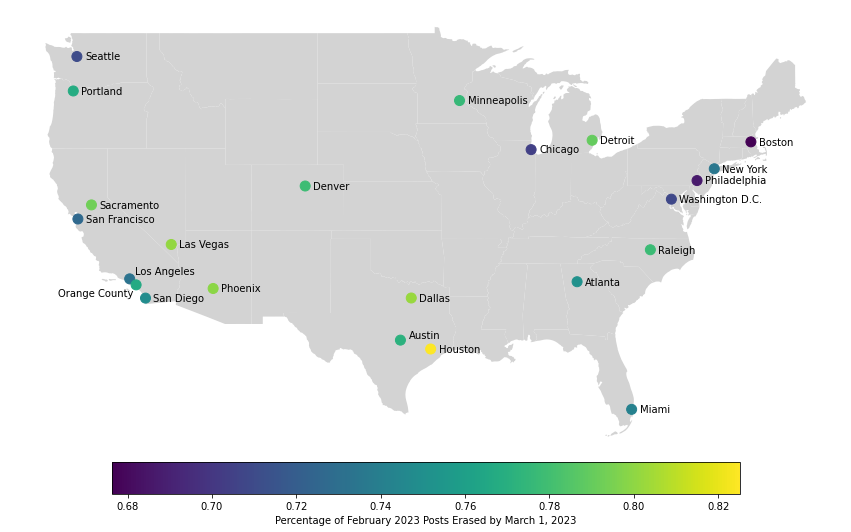

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
states_48.plot(color='lightgrey',
                    figsize=(15, 10),
                    ax=ax)

pct_erased_by_city = pd.DataFrame(data['fig2'])
pct_erased_by_city_gdf = gpd.GeoDataFrame(
    pct_erased_by_city,
    geometry=gpd.points_from_xy(pct_erased_by_city.longitude,
                                pct_erased_by_city.latitude),
    crs='EPSG:4326'
)

pct_erased_by_city_gdf.plot(ax=ax,
                            markersize=100,
                            cmap='viridis',
                            column='pct_erased',
                            legend=True,
                            legend_kwds={'shrink': 0.75,
                                         'orientation': 'horizontal',
                                         'label': 'Percentage of February 2023 Posts Erased by March 1, 2023',
                                         'pad': 0.01})\
                      .set_axis_off()

pct_erased_by_city_gdf.apply(label_cities, axis=1)

# save to file
plt.savefig('figure2.pdf', dpi=300, format="pdf", bbox_inches="tight")


### Figure 3: Modeling Overall Post Hours-to-erasure

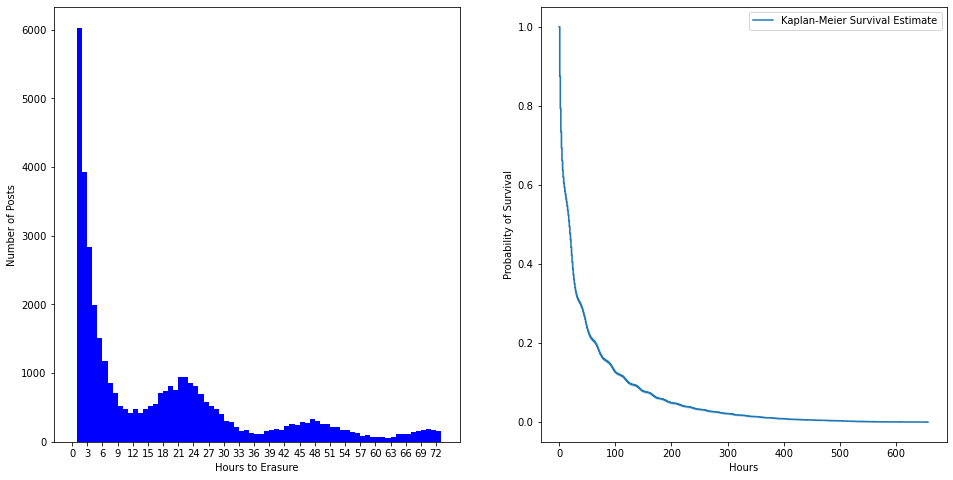

In [3]:
binSides, binCounts = data['fig3']
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Left Subplot: Overall Hours-to-Erasure Histogram
l_counts_subset = binCounts[:(3 * 24 + 1)]
l_sides_subset = binSides[:(3 * 24 + 2)]
N = len(l_counts_subset)
ind = np.arange(N)
width = 1
rects1 = ax[0].bar(ind + 0.5, l_counts_subset, width, color='b')
ax[0].set_xlabel('Hours to Erasure')
ax[0].set_ylabel('Number of Posts')
ax[0].set_xticks(np.arange(0, 3 * 24 + 1, 3))
ax[0].set_xticklabels(np.arange(0, 3 * 24 + 1, 3))

# Right Subplot: KM Survival Curve
durations_overall = np.repeat(binSides[:-1], binCounts)
kmf.fit(durations_overall)
kmf.plot(ax=ax[1], 
         label='Kaplan-Meier Survival Estimate', 
         xlabel='Hours', 
         ylabel='Probability of Survival')

# save to file
plt.savefig('figure3.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 4: Number of Posts Surviving through March 1, 2023, compared with the total number of new posts each day in February 2023.

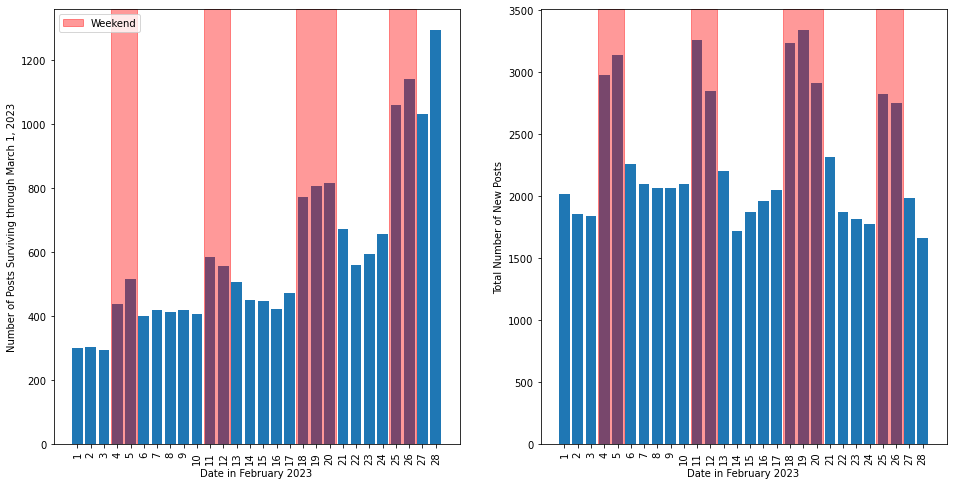

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Left Subplot: Non-erased Overall Counts by Day
binSides, binCounts = data['fig4_l']
N = len(binCounts)
ind = np.arange(1, N + 1)

ax[0].bar(ind, binCounts[::-1])
ax[0].set_ylabel('Number of Posts Surviving through March 1, 2023')
ax[0].set_xticks(ind)
ax[0].set_xticklabels(ind, rotation=90)
ax[0].set_xlabel('Date in February 2023')

# Right Subplot: Total Number of posts by day in February 
overall_posts_by_day = data['fig4_r']

ax[1].bar(ind, overall_posts_by_day[::-1])
ax[1].set_ylabel('Total Number of New Posts')
ax[1].set_xticks(ind)
ax[1].set_xticklabels(ind, rotation=90)
ax[1].set_xlabel('Date in February 2023')

# Highlight weekends in both subplots; Note that Feb 20th was a Federal Holiday
# (Presidents Day), making Feb 18-20th a 3-day weekend
weekends = [(4, 5), (11, 12), (18, 20), (25, 26)]
for i, we in enumerate(weekends):
    ax[0].axvspan(we[0] - 0.5, we[1] + 0.5, color='r', alpha=0.4,
                  label='_'*i + 'Weekend')
    ax[1].axvspan(we[0] - 0.5, we[1] + 0.5, color='r', alpha=0.4)
ax[0].legend()

# save to file
plt.savefig('figure4.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 5: Comparing the spatial distribution of surviving items overall on March 1, 2023 to the spatial distribution of all items posted in the preceding month

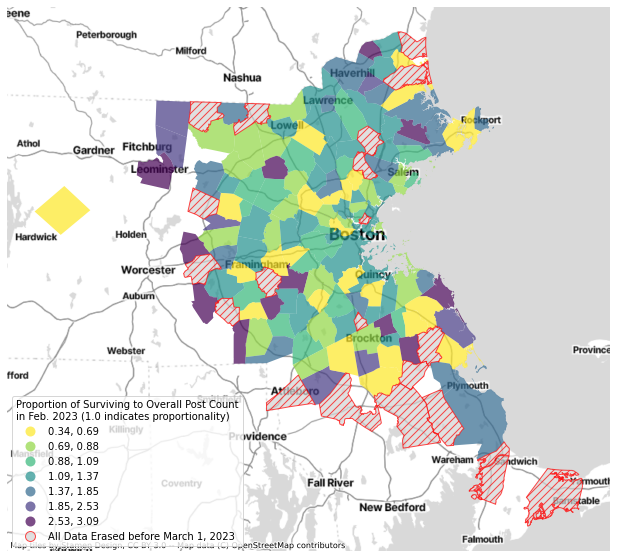

In [5]:
ax = compare_proportions_overall.plot(
        column='ratio',
        cmap='viridis_r',
        scheme='natural_breaks',
        k=7,
        figsize=(15,10),
        alpha=0.7,
        legend=True,
        legend_kwds={
            'loc': 'lower left',
            'title': 'Proportion of Surviving to Overall Post Count\nin Feb. 2023 (1.0 indicates proportionality)'
        },
        missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'red',
        'hatch': '///',
        'label': 'All Data Erased before March 1, 2023'
        }
)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

# save to file
plt.savefig('figure5.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 6: Regional KM Survival Curves

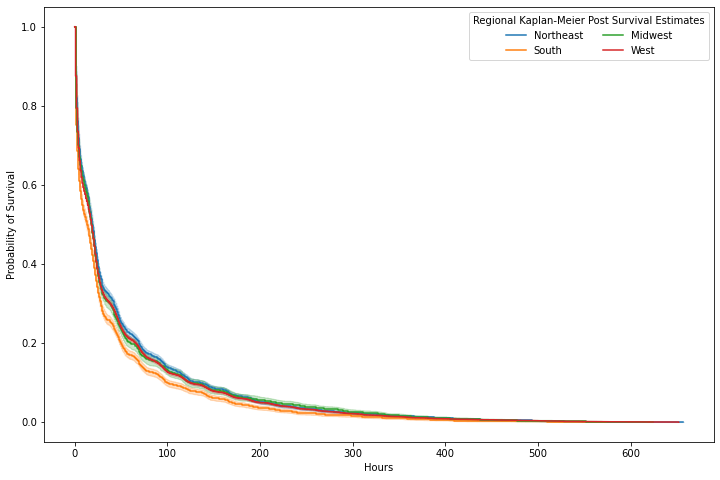

In [6]:
pdf_cats_city_region = pd.DataFrame(data['fig6_7'])

fig, ax = plt.subplots(figsize=(12, 8))

regions = ['northeast', 'south', 'midwest', 'west']
for r in regions:
    r_df = pdf_cats_city_region[pdf_cats_city_region['region'] == r]
    kmf.fit(r_df['hours_active'], label=r.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Regional Kaplan-Meier Post Survival Estimates', ncol=2)

# save to file
plt.savefig('figure6.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 7: Categorical KM Post Survival Curves

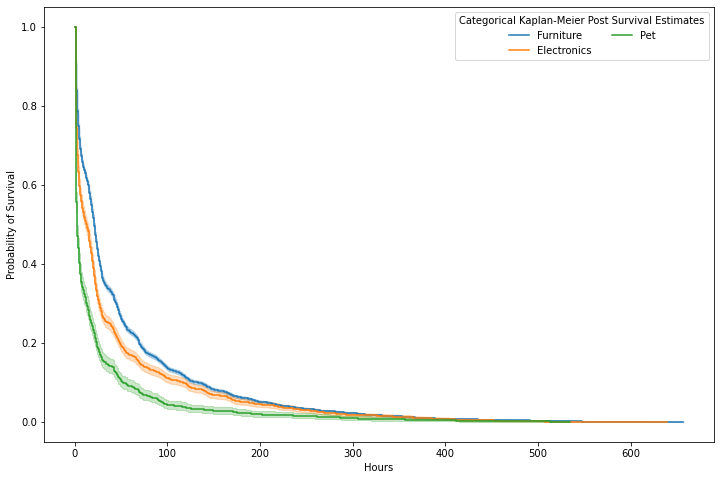

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

categories = ['furniture', 'electronics', 'pet']
for cat in categories:
    c_df = pdf_cats_city_region[pdf_cats_city_region['top_category'] == cat]
    kmf.fit(c_df['hours_active'], label=cat.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Categorical Kaplan-Meier Post Survival Estimates', ncol=2)

# save to file
plt.savefig('figure7.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 8: Comparing the spatial distribution (by category) of surviving items on March 1, 2023 to the spatial distribution of all items posted in the preceding month

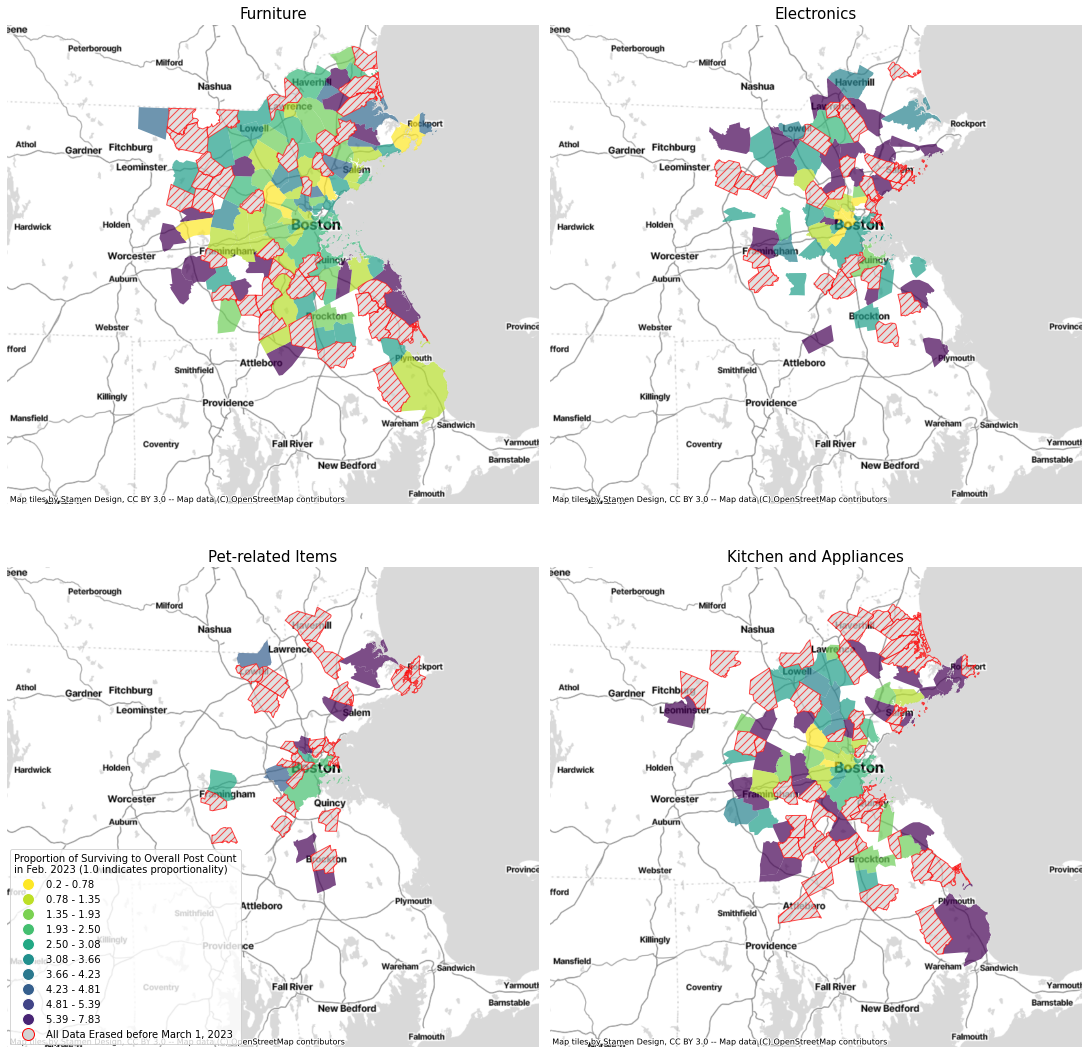

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15),
                       constrained_layout=True)
ax = ax.ravel()

gdf_dict = {'Furniture': compare_proportions['furniture'],
            'Electronics': compare_proportions['electronics'],
            'Pet-related Items': compare_proportions['pet'],
            'Kitchen and Appliances': compare_proportions['kitchen']
}

bins = mapclassify.EqualInterval(gdf_dict['Furniture']['ratio'], k=10).bins

for i, k in enumerate(gdf_dict.keys()):
    minx, maxx = (-8048669.1898469515, -7810438.688961195)
    ax[i].set_xlim(minx, maxx)
    miny, maxy = (5089633.422959745, 5304521.805669296)
    ax[i].set_ylim(miny, maxy)

    gdf_dict[k].plot(ax=ax[i],
                     figsize=(10,10),
                     column='ratio',
                     cmap='viridis_r',
                     scheme='user_defined',
                     k=10,
                     classification_kwds=dict(bins=list(bins)),
                     alpha=0.7,
                     missing_kwds={
                        'color': 'lightgrey',
                        'edgecolor': 'red',
                        'hatch': '///',
                     }
    )

    cx.add_basemap(ax[i], source=cx.providers.Stamen.TonerLite)
    ax[i].set_axis_off()
    ax[i].set_title(str(k), size=15)

cmap = cm.get_cmap('viridis_r')

# Create custom legend mapping onto color map levels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='0.2 - 0.78',
           markerfacecolor=cmap(0.0), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='0.78 - 1.35',
           markerfacecolor=cmap(0.1), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='1.35 - 1.93',
           markerfacecolor=cmap(0.2), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='1.93 - 2.50',
           markerfacecolor=cmap(0.3), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='2.50 - 3.08',
           markerfacecolor=cmap(0.4), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='3.08 - 3.66',
           markerfacecolor=cmap(0.5), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='3.66 - 4.23',
           markerfacecolor=cmap(0.6), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='4.23 - 4.81',
           markerfacecolor=cmap(0.7), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='4.81 - 5.39',
           markerfacecolor=cmap(0.8), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='5.39 - 7.83',
           markerfacecolor=cmap(0.9), markersize=12),
    Line2D([0], [0], marker='o', color='red',
           label='All Data Erased before March 1, 2023',
           markerfacecolor='lightgrey', markersize=12, linestyle='')
]

fig.legend(handles=legend_elements,
           loc='lower left', 
           title='Proportion of Surviving to Overall Post Count\nin Feb. 2023 (1.0 indicates proportionality)',
           bbox_to_anchor=[0.001, 0.025])

# save to file
plt.savefig('figure8.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 9: Overall KM Edit Survival Curve

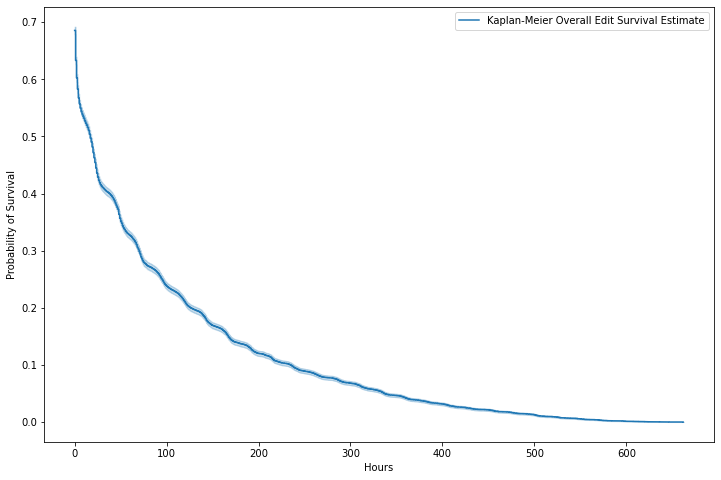

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

time_to_edit_hist_bins = data['fig9']
durations_overall = np.repeat(time_to_edit_hist_bins[0][:-1],
                              time_to_edit_hist_bins[1])
kmf.fit(durations_overall, label='Kaplan-Meier Overall Edit Survival Estimate')
kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

# save to file
plt.savefig('figure9.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 11: Regional KM Edit Survival Curves

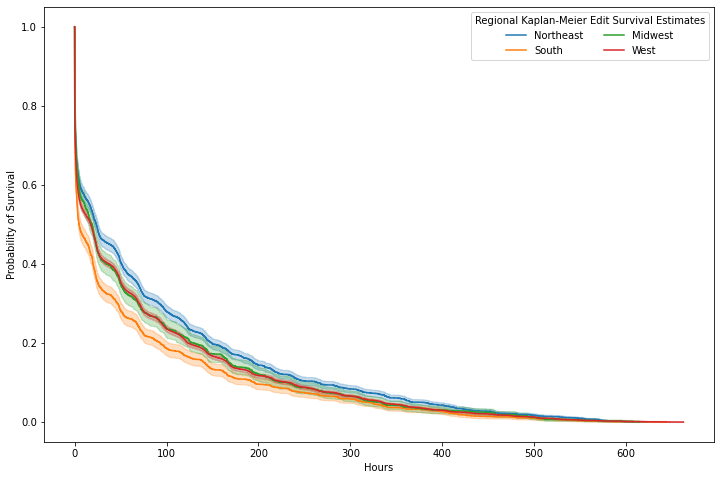

In [10]:
pdf_cats_city_region_edit = pd.DataFrame(data['fig11_12'])

fig, ax = plt.subplots(figsize=(12, 8))
for r in regions:
    region_mask = pdf_cats_city_region_edit['region'] == r
    kmf.fit(pdf_cats_city_region_edit[region_mask]['duration'], 
            label=r.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Regional Kaplan-Meier Edit Survival Estimates', ncol=2)

# save to file
plt.savefig('figure11.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 12: Categorical KM Edit Survival Curves

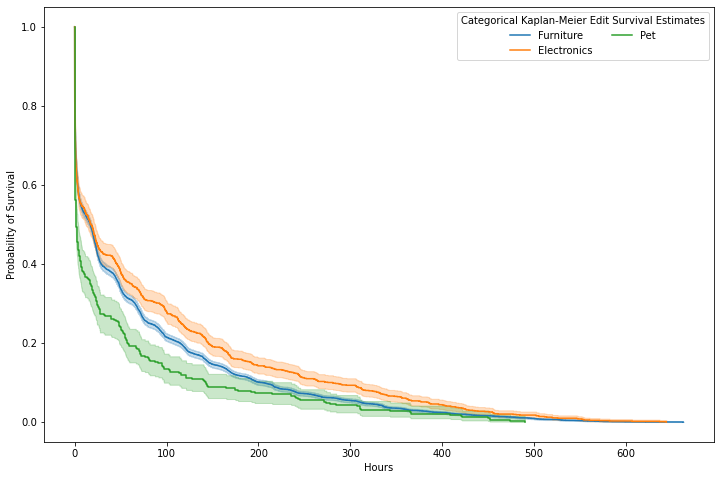

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
for cat in categories:
    cat_mask = pdf_cats_city_region_edit['top_category'] == cat
    c_df = pdf_cats_city_region_edit['duration'][cat_mask]
    kmf.fit(c_df, label=cat.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Categorical Kaplan-Meier Edit Survival Estimates', ncol=2)

# save to file
plt.savefig('figure12.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 13: Overall ratio of posts from census tracts in persistent poverty versus posts from other census tracts

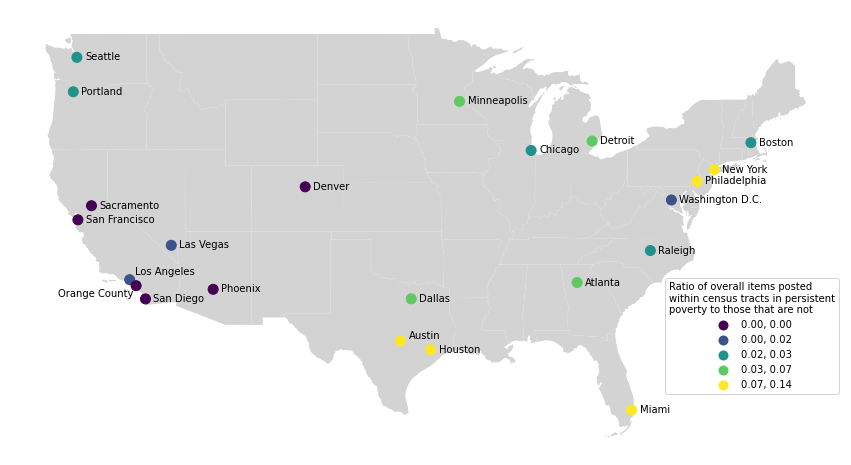

In [12]:
erasure_ratio_pov_not = pd.merge(left=pov.groupby('city').hours_active.count(), 
         right=not_pov.groupby('city').hours_active.count(),
         on='city',
         how='outer') \
       .fillna(0)
erasure_ratio_pov_not.columns = ['pov', 'not_pov']
erasure_ratio_pov_not.loc[:, 'ratio_pov_to_not'] = erasure_ratio_pov_not.pov / erasure_ratio_pov_not.not_pov

non_erasure_ratio_pov_not = pd.merge(left=pov_non.groupby('city').hours_active.count(), 
                                     right=not_pov_non.groupby('city').hours_active.count(),
                                     on='city',
                                     how='outer') \
                              .fillna(0)
non_erasure_ratio_pov_not.columns = ['pov', 'not_pov']
non_erasure_ratio_pov_not.loc[:, 'ratio_pov_to_not'] = non_erasure_ratio_pov_not.pov / non_erasure_ratio_pov_not.not_pov

overall = non_erasure_ratio_pov_not + erasure_ratio_pov_not
overall.loc[:, 'ratio_pov_to_not'] = overall.pov / overall.not_pov

fig, ax = plt.subplots(1, 1, figsize=(15,10))
states_48.plot(color='lightgrey',
                    figsize=(15, 10),
                    ax=ax)

# use Figure 2 lon/lat designations for cities
pct_erased_by_city = pd.DataFrame(data['fig2'])
pov_to_not_by_city = pct_erased_by_city.join(erasure_ratio_pov_not.ratio_pov_to_not, on='city') \
                                       .join(non_erasure_ratio_pov_not.ratio_pov_to_not, on='city', rsuffix='_non_erased') \
                                       .join(overall.ratio_pov_to_not, on='city', rsuffix='_overall')

pov_to_not_by_city_gdf = gpd.GeoDataFrame(
    pov_to_not_by_city,
    geometry=gpd.points_from_xy(pov_to_not_by_city.longitude,
                                pov_to_not_by_city.latitude),
    crs='EPSG:4326'
)

pov_to_not_by_city_gdf.plot(ax=ax,
                            markersize=100,
                            cmap='viridis',
                            column='ratio_pov_to_not_overall',
                            legend=True,
                            scheme='quantiles'
                            )\
                      .set_axis_off()

pct_erased_by_city_gdf.apply(label_cities, axis=1);

legend = ax.get_legend()
legend.set_bbox_to_anchor((1.0, 0.41))
legend.set_title('Ratio of overall items posted\nwithin census tracts in persistent\npoverty to those that are not')

# save to file
plt.savefig('figure13.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 14: Percent Difference between Proportion of ``Free Stuff'' Posts by Most Prevalant Race or Ethnic Group in a U.S. Census Tract and that Group's Proportion of Overall U.S. Population

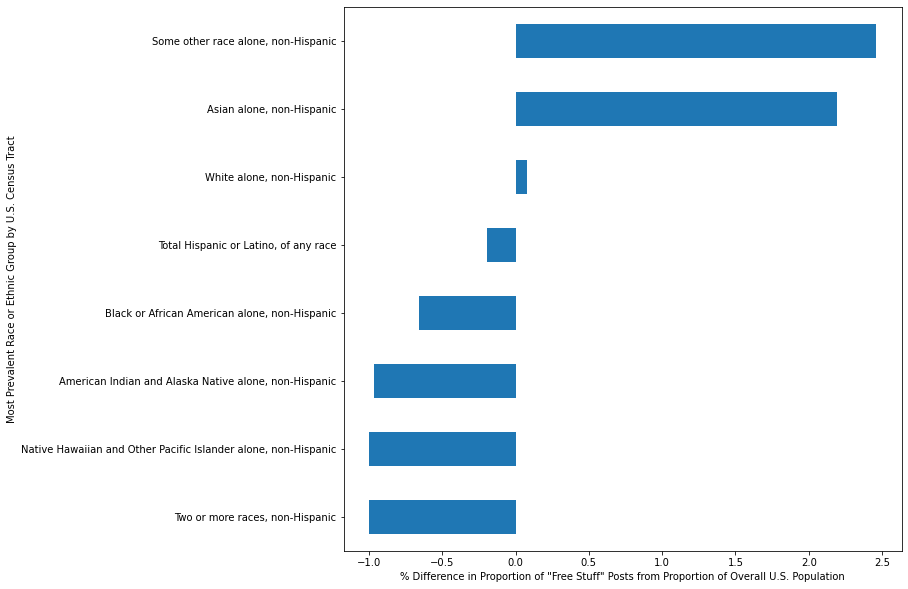

In [13]:
overall_by_tract = pd.concat([erasure_by_tract, non_erasure_by_tract])

fig, ax = plt.subplots(figsize=(10, 10))
df = pd.merge(acs_race_eth_overall_prop,
              overall_by_tract.groupby(['most_prev']).GEOID.count() / overall_by_tract.GEOID.count(),
              on='most_prev',
              how='left') \
       .fillna(0)

df.rename(columns={'GEOID_x': 'acs', 'GEOID_y': 'post_tracts'},
          inplace=True)

df_diff = pd.DataFrame(((df.post_tracts - df.acs) / df.acs), columns=['diff'])
df_diff.sort_values(by=['diff', 'most_prev'], 
                    ascending=[True, False],
                    inplace=True)
df_diff.plot(kind='barh', ax=ax, legend=False)
plt.ylabel('Most Prevalent Race or Ethnic Group by U.S. Census Tract')
plt.xlabel('% Difference in Proportion of "Free Stuff" Posts from Proportion of Overall U.S. Population')

# save to file
plt.savefig('figure14.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 15: Kaplan-Meier Time-to-erasure and Time-to-edit Survival Curves by Persistent Poverty Status

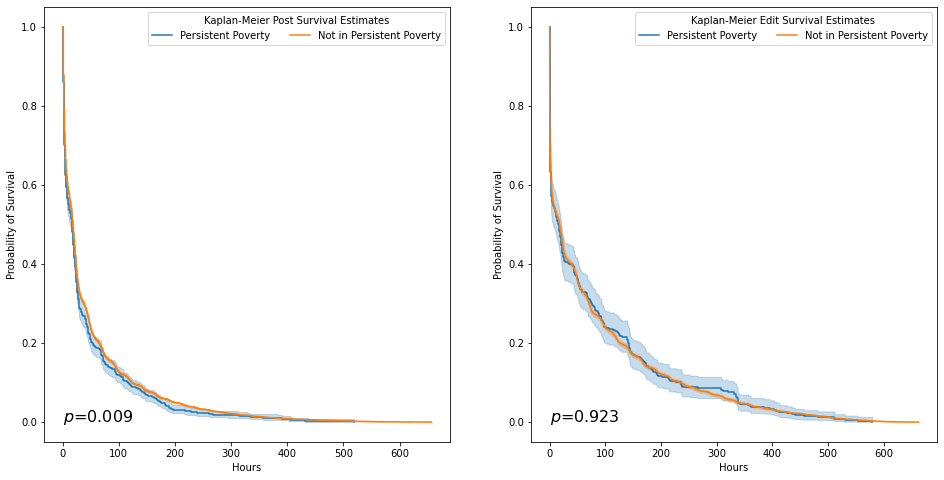

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

by_tract = {'erasure': {'full': erasure_by_tract,
                        'Persistent Poverty': pov,
                        'Not in Persistent Poverty': not_pov},
            'edit':    {'full': edit_by_tract,
                        'Persistent Poverty': pov_edit,
                        'Not in Persistent Poverty': not_pov_edit}}

for i, t in enumerate(['erasure', 'edit']):
    for k, df in by_tract[t].items():
        if k == 'full':
            log_rank = pairwise_logrank_test(df['hours_active'],
                                             df['persistent_poverty'])
            p = round(log_rank.summary.p.values[0], 3)
        else:
            kmf.fit(df['hours_active'], label=k)
            kmf.plot(ax=ax[i], xlabel='Hours', ylabel='Probability of Survival')

    if t == 'erasure':
        plot_type = 'Post'
    else:
        plot_type = 'Edit'
    ax[i].legend(title=f'Kaplan-Meier {plot_type} Survival Estimates', ncol=2)
    ax[i].text(0, 0, f"$\it{'p'}$={p}", fontsize=16)

# save to file
plt.savefig('figure15.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 16: Kaplan-Meier Time-to-erasure and Time-to-edit Survival Curves by Most Prevalent Race or Ethnic Group in U.S. Census Tract

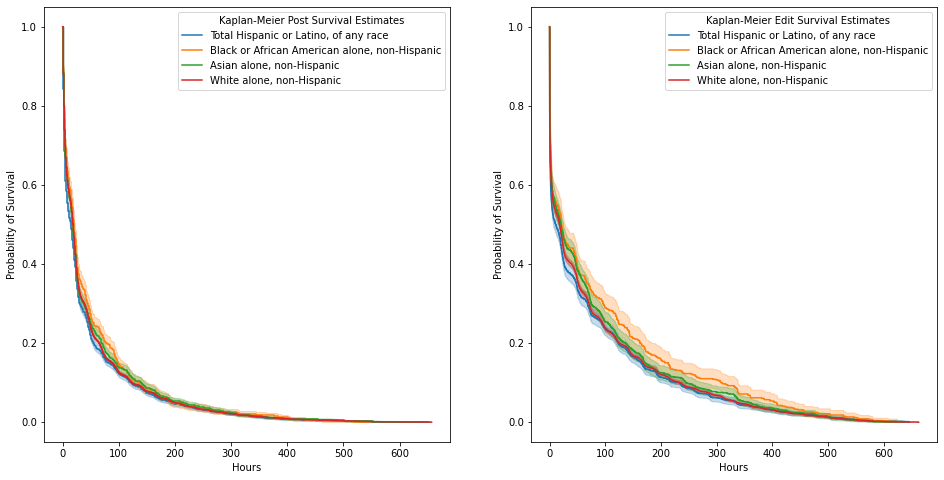

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

by_tract = {'erasure': {'full': erasure_by_tract,
                        'Total Hispanic or Latino, of any race': erasure_by_tract[erasure_by_tract.most_prev == 'Total Hispanic or Latino, of any race'],
                        'Black or African American alone, non-Hispanic': erasure_by_tract[erasure_by_tract.most_prev == 'Black or African American alone, non-Hispanic'],
                        'Asian alone, non-Hispanic': erasure_by_tract[erasure_by_tract.most_prev == 'Asian alone, non-Hispanic'],
                        'White alone, non-Hispanic': erasure_by_tract[erasure_by_tract.most_prev == 'White alone, non-Hispanic'],
                        },
            'edit':    {'full': edit_by_tract,
                        'Total Hispanic or Latino, of any race': edit_by_tract[edit_by_tract.most_prev == 'Total Hispanic or Latino, of any race'],
                        'Black or African American alone, non-Hispanic': edit_by_tract[edit_by_tract.most_prev == 'Black or African American alone, non-Hispanic'],
                        'Asian alone, non-Hispanic': edit_by_tract[edit_by_tract.most_prev == 'Asian alone, non-Hispanic'],
                        'White alone, non-Hispanic': edit_by_tract[edit_by_tract.most_prev == 'White alone, non-Hispanic'],
                        }}

for i, t in enumerate(['erasure', 'edit']):
    for k, df in by_tract[t].items():
        if k != 'full':
            kmf.fit(df['hours_active'], label=k)
            kmf.plot(ax=ax[i], xlabel='Hours', ylabel='Probability of Survival')

    if t == 'erasure':
        plot_type = 'Post'
    else:
        plot_type = 'Edit'
    ax[i].legend(title=f'Kaplan-Meier {plot_type} Survival Estimates', ncol=1)

# save to file
plt.savefig('figure16.pdf', dpi=300, format="pdf", bbox_inches="tight")

P-values indicating statistically significant differences between survival estimates above:

In [16]:
for l, df in zip(['Erasure', 'Edit'], [erasure_by_tract, edit_by_tract]):
    mask = df.most_prev.isin(['Black or African American alone, non-Hispanic', 
                                'Asian alone, non-Hispanic',
                                'Total Hispanic or Latino, of any race',
                                'White alone, non-Hispanic'])
    log_rank = pairwise_logrank_test(df[mask]['hours_active'],
                                    df[mask]['most_prev'])

    print('###################################################################')
    print(l)
    print('###################################################################')
    log_rank.print_summary()

###################################################################
Erasure
###################################################################


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                                                             test_statistic      p  -log2(p)
Asian alone, non-Hispanic                     Black or African American alone, non-Hispanic            2.00   0.16      2.67
                                              Total Hispanic or Latino, of any race                   12.23 <0.005     11.05
                                              White alone, non-Hispanic                                1.07   0.30      1.73
Black or African American alone, non-Hispanic Total Hispanic or Latino, of any race                   18.36 <0.005     15.74
                                              White alone, non-Hispanic                                6.31   0.01      6.38
Total Hispanic or Latino, of any race         White alone, non-Hispanic                               18.95 <0.005     16.19

###################################################################
Edit
###################################################################


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                                                             test_statistic      p  -log2(p)
Asian alone, non-Hispanic                     Black or African American alone, non-Hispanic            3.08   0.08      3.65
                                              Total Hispanic or Latino, of any race                    4.70   0.03      5.06
                                              White alone, non-Hispanic                                2.01   0.16      2.68
Black or African American alone, non-Hispanic Total Hispanic or Latino, of any race                   12.00 <0.005     10.88
                                              White alone, non-Hispanic                                9.61 <0.005      9.01
Total Hispanic or Latino, of any race         White alone, non-Hispanic                                2.63   0.11      3.25

### Figure 17: Proportion of Material Category by Persistent Poverty Status in U.S. Census Tract

Asterisks (*) denote categories that were the largest contributors to the overall chi-square statistic (i.e. categories where the proportions were significantly different from one another at the $\alpha=0.05$ level).

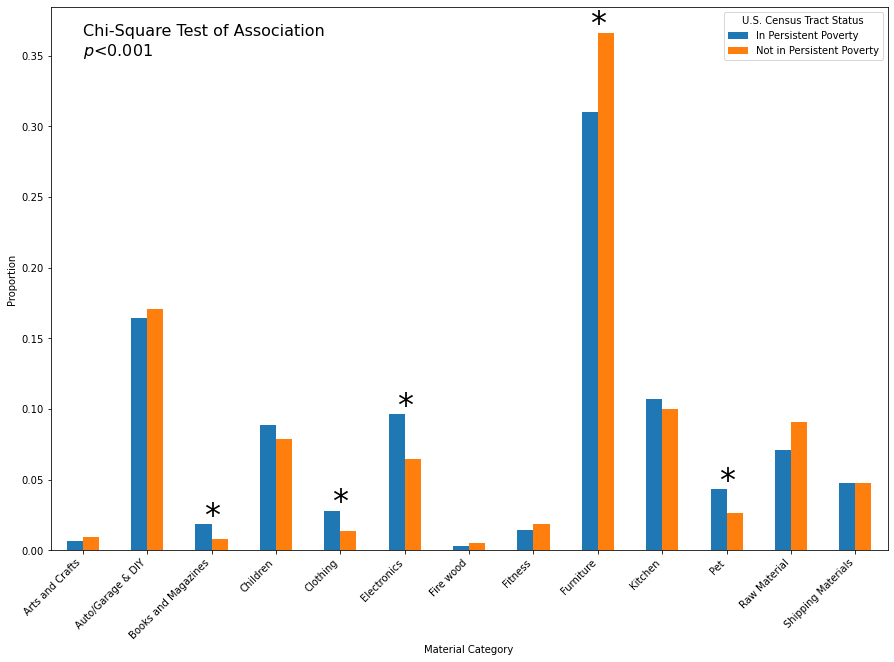

In [17]:
pov_overall = overall_by_tract[overall_by_tract.persistent_poverty]
not_pov_overall = overall_by_tract[~overall_by_tract.persistent_poverty]

cat_freqs = pd.merge(pov_overall.groupby('category')
                                .geometry
                                .count(),
                     not_pov_overall.groupby('category') \
                                    .geometry \
                                    .count(),
                     on='category',
                     suffixes=['_pov', '_not_pov']) \
              .rename(columns={'geometry_pov': 'pov', 
                               'geometry_not_pov': 'not_pov'})
# hold out items in "other" category from calculations
cat_freqs = cat_freqs[cat_freqs.index != 'other']
cat_freqs = sm.stats.Table(cat_freqs)

chi2_p = cat_freqs.test_nominal_association().pvalue
if chi2_p < 0.001:
    p_str = "Chi-Square Test of Association\n$\it{p}$<0.001"
else:
    p = round(chi2_p, 3)
    p_str = f"Chi-Square Test of Association\n$\it{'p'}$={p}"

stdres = cat_freqs.standardized_resids.pov
df = pd.DataFrame({'In Persistent Poverty': cat_freqs.table_orig.pov 
                                       / sum(cat_freqs.table_orig.pov),
                   'Not in Persistent Poverty': cat_freqs.table_orig.not_pov 
                                       / sum(cat_freqs.table_orig.not_pov)
    }
)
alpha = 0.05
nrow = cat_freqs.standardized_resids.shape[0]
ncol = cat_freqs.standardized_resids.shape[1]
threshold = norm.ppf(1 - ((alpha / 2) / (nrow * ncol)))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

bar = df.plot(kind='bar', ax=ax)
max_vals = df.max(axis=1)
for i, m, p in zip(stdres, max_vals, bar.patches):
    if abs(i) > threshold:
        ax.text(p.get_x() + p.get_width(),
                 m,
                 '*',
                 ha='center',
                 fontsize=32)

ax.legend(title='U.S. Census Tract Status')
ax.set_xlabel('Material Category')
ax.set_ylabel('Proportion')
xticklabels = ['Arts and Crafts', 'Auto/Garage & DIY', 'Books and Magazines', 'Children', 'Clothing', 'Electronics', 'Fire wood', 'Fitness', 'Furniture', 'Kitchen', 'Pet', 'Raw Material', 'Shipping Materials']
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.text(0, .35, p_str, fontsize=16)

# save to file
plt.savefig("figure17.pdf", dpi=300, format="pdf", bbox_inches="tight")

### Figure 18: Proportion of Material Category by Most Prevalent Race or Ethnic Group in U.S. Census Tract

Asterisks (*) denote categories that were the largest contributors to the overall chi-square statistic (i.e. categories where the proportions were significantly different from one another at the $\alpha=0.05$ level).

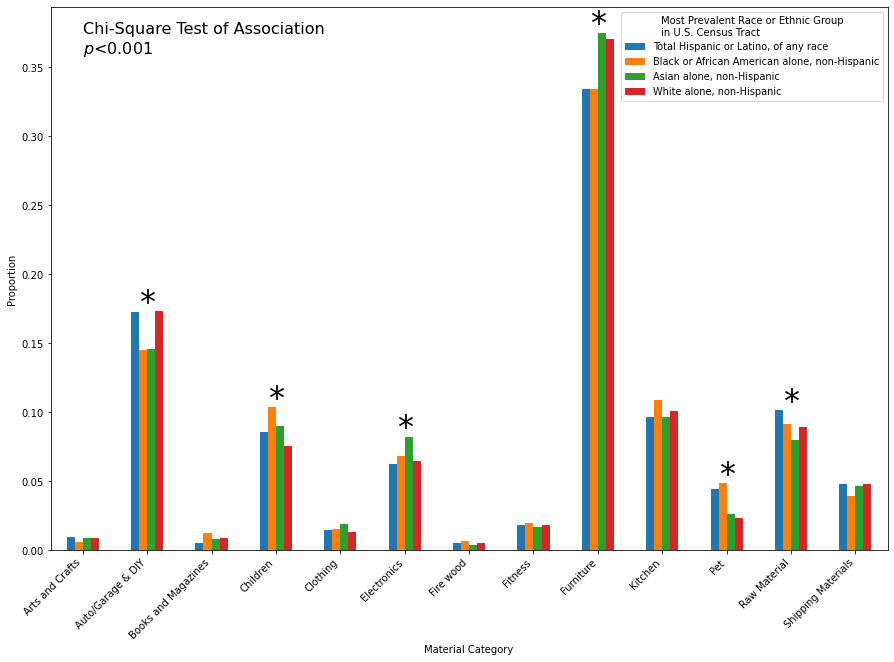

In [18]:
race_eth_overall = {'Total Hispanic or Latino, of any race': overall_by_tract[overall_by_tract.most_prev == 'Total Hispanic or Latino, of any race'],
 'Black or African American alone, non-Hispanic': overall_by_tract[overall_by_tract.most_prev == 'Black or African American alone, non-Hispanic'],
 'Asian alone, non-Hispanic': overall_by_tract[overall_by_tract.most_prev == 'Asian alone, non-Hispanic'],
 'White alone, non-Hispanic': overall_by_tract[overall_by_tract.most_prev == 'White alone, non-Hispanic'],
}

cat_freqs = race_eth_overall['Total Hispanic or Latino, of any race'].groupby('category') \
                                                                      .geometry \
                                                                      .count()

# hold out items in "other" category from calculations
cat_freqs = cat_freqs[cat_freqs.index != 'other']
count = 0
for k, df in race_eth_overall.items():
       if k != 'Total Hispanic or Latino, of any race':
              to_merge = df.groupby('category') \
                           .geometry \
                           .count()
              cat_freqs = pd.merge(to_merge,
                                   cat_freqs,
                                   on='category',
                                   suffixes=(f'_{count + 1}', f'_{count}'))
       count += 1
cat_freqs = sm.stats.Table(cat_freqs)

stdres = cat_freqs.standardized_resids
df = pd.DataFrame({'Total Hispanic or Latino, of any race': cat_freqs.table_orig.loc[:, 'geometry_1']
                                       / sum(cat_freqs.table_orig.loc[:, 'geometry_1']),
                   'Black or African American alone, non-Hispanic': cat_freqs.table_orig.loc[:, 'geometry_2']
                                       / sum(cat_freqs.table_orig.loc[:, 'geometry_2']),
                   'Asian alone, non-Hispanic': cat_freqs.table_orig.loc[:, 'geometry_3']
                                       / sum(cat_freqs.table_orig.loc[:, 'geometry_3']),
                   'White alone, non-Hispanic': cat_freqs.table_orig.loc[:, 'geometry_4']
                                       / sum(cat_freqs.table_orig.loc[:, 'geometry_4'])
    }
)

chi2_p = cat_freqs.test_nominal_association().pvalue
if chi2_p < 0.001:
    p_str = "Chi-Square Test of Association\n$\it{p}$<0.001"
else:
    p = round(chi2_p, 3)
    p_str = f"Chi-Square Test of Association\n$\it{'p'}$={p}"

alpha = 0.05
nrow = stdres.shape[0]
ncol = stdres.shape[1]
threshold = norm.ppf(1 - ((alpha / 2) / (nrow * ncol)))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bar = df.plot(kind='bar', ax=ax)
max_vals = df.max(axis=1)
sig_stdres = ((stdres > threshold) | (stdres < -threshold)).sum(axis=1)
for i, m, p in zip(sig_stdres, max_vals, bar.patches):
    if i > 0:
        ax.text(p.get_x() + p.get_width() * 2,
                m,
                 '*',
                 ha='center',
                 fontsize=32)

ax.legend(title='Most Prevalent Race or Ethnic Group\nin U.S. Census Tract', fontsize=9.75)
ax.set_xlabel('Material Category')
ax.set_ylabel('Proportion')
xticklabels = ['Arts and Crafts', 'Auto/Garage & DIY', 'Books and Magazines', 'Children', 'Clothing', 'Electronics', 'Fire wood', 'Fitness', 'Furniture', 'Kitchen', 'Pet', 'Raw Material', 'Shipping Materials']
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.text(0, .36, p_str, fontsize=16)

# save to file
plt.savefig("figure18.pdf", dpi=300, format="pdf", bbox_inches="tight")